In [3]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
%matplotlib inline

import sys
import os
import matplotlib.pyplot as plt

import numpy as np
sys.path.append("/")  # enable import of "recipe"
os.chdir("/work/")

from recipes.main import load_experiment
experiment = load_experiment(recipe="_2020_04_08_tinyimgnet_baselines", 
                             experiment="tinyimgnet_BW", 
                             schema="shahd_tinyimgnet_baselines",  # schema name will automatically be generated from recipe and experiment names 
                             base_dir="/recipes/", 
                             import_prefix="recipes.", 
                             dev_mode=False  # this installs and imports the current head of all repos 
                            )
from bias_transfer.tables.trained_model import *
from bias_transfer.tables.trained_transfer_model import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select TrainedModel

In [4]:
exp = next(iter(experiment.experiments.values()))
rest = exp.get_restrictions()
(TrainedModel & rest)

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
bias_transfer.models.classification_cnn_builder,e80f2509f91cf40daa606a962f0c9fd3,bias_transfer.dataset.img_dataset_loader,239ce0d0590e37bd405e0b65a4dada83,bias_transfer.trainer.trainer,76345b589c526fd53dccf22c0dded323,1000,opt_SGD_lr_0.1_lrDecay_0.4_seed_1000.vgg19_bn_conv_grayscaleInput.TinyImgNet_B&W,49.51,=BLOB=,Shahd,2021-02-15 11:41:18


# Reconstruction

In [4]:
# get all tables
from reconstruction.schema.main import *

## Image table

In [5]:
ReconstructionImages()

img_id unique id,img_class,image actual image
0,vgg,=BLOB=
1,vgg,=BLOB=


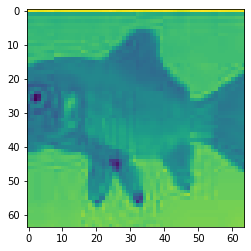

In [9]:
plt.imshow((ReconstructionImages & dict(img_id=0)).fetch1("image").squeeze()[0])

# Seed Table

In [ ]:
ReconSeed().insert1(dict(mei_seed=1000), skip_duplicates=True)

In [9]:
ReconSeed()

mei_seed MEI seed
1000


# TargetFunction Table

In [9]:
key = dict(target_fn= 'reconstruction.optimization.targets.gauss_loss',
          target_config = {'mean': True},
          target_comment = 'default MSE loss')

In [10]:
ReconTargetFunction().add_entry(**key)

{'target_fn': 'reconstruction.optimization.targets.gauss_loss',
 'target_hash': 'ceaf1499a7c83d9882a6160662381637',
 'target_config': {'mean': True},
 'target_comment': 'default MSE loss'}

In [23]:
ReconTargetFunction()

target_fn,target_hash,target_config,target_comment
reconstruction.optimization.targets.gauss_loss,ceaf1499a7c83d9882a6160662381637,=BLOB=,default MSE loss


# TargetUnit Table

### LayerGetter Utils

In [25]:
unit_fn = 'reconstruction.modules.wrappers.IntermediateLayerModelVGG'
unit_config = dict(return_layer = {'7': 'model.features.7',})

In [7]:
model_key = (Model & rest).proj().fetch1("KEY")
unit_comment = "model.features.0 loop"

In [10]:
ReconTargetUnit().add_entry(**model_key, unit_fn=unit_fn,unit_config=unit_config, unit_comment=unit_comment)

{'model_fn': 'bias_transfer.models.classification_cnn_builder',
 'model_hash': 'e80f2509f91cf40daa606a962f0c9fd3',
 'unit_hash': 'a79e554296f18c181b4b511d80c4da1d',
 'unit_fn': 'reconstruction.modules.wrappers.IntermediateLayerModelVGGLoop',
 'unit_config': {'layer': 0},
 'unit_comment': 'model.features.0 loop'}

In [11]:
ReconTargetUnit()

model_fn name of the model function,model_hash hash of the model configuration,unit_fn,unit_hash,unit_config list of unit_ids,unit_comment
bias_transfer.models.classification_cnn_builder,e80f2509f91cf40daa606a962f0c9fd3,reconstruction.modules.wrappers.IntermediateLayerModelVGG,0c80fc8c3513dc8847547c4d8074bca8,=BLOB=,model.features.3
bias_transfer.models.classification_cnn_builder,e80f2509f91cf40daa606a962f0c9fd3,reconstruction.modules.wrappers.IntermediateLayerModelVGG,1f4e202cf4cf105b3fd75058a69e3a88,=BLOB=,model.features.0
bias_transfer.models.classification_cnn_builder,e80f2509f91cf40daa606a962f0c9fd3,reconstruction.modules.wrappers.IntermediateLayerModelVGG,4c5b668c40ba68792443f905ee552ca3,=BLOB=,model.features.7
bias_transfer.models.classification_cnn_builder,e80f2509f91cf40daa606a962f0c9fd3,reconstruction.modules.wrappers.IntermediateLayerModelVGGLoop,a79e554296f18c181b4b511d80c4da1d,=BLOB=,model.features.0 loop


# Objective Table

In [24]:
# combines Functions and Units to a single Objective
ReconObjective().populate(display_progress=True)

0it [00:00, ?it/s]


# Method Table

In [18]:
for norm in [5, 10, 20, 40, 60]:
    method_fn = 'mei.methods.gradient_ascent'
    method_config = {'initial': {'path': 'reconstruction.optimization.initial.RandomNormalRGB',},
     'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 5000}},
     'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
      'kwargs': {'sigma': 1, }},
     'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
      'kwargs': {'norm': norm, }},
     'stopper': {'path': 'mei.stoppers.NumIterations',
      'kwargs': {'num_iterations': 5000}},
     'objectives': [{'path': 'mei.objectives.EvaluationObjective',
       'kwargs': {'interval': 10}}],
     'device': 'cuda',}
    ReconMethod().add_method(method_fn, method_config, f"lr=5000, norm={norm}")

In [13]:
ReconMethod()

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method
mei.methods.gradient_ascent,2d3f71ccb1bb3fe780ce932485eb697c,=BLOB=,2021-04-16 17:10:31,"lr=5000, norm=20"
mei.methods.gradient_ascent,94d9285e922add59c52d6fca93170b43,=BLOB=,2021-04-16 17:10:31,"lr=5000, norm=5"
mei.methods.gradient_ascent,a338477fa2bd16bf790e325a598cb013,=BLOB=,2021-04-16 17:10:31,"lr=5000, norm=40"
mei.methods.gradient_ascent,eb95273a2972d741da688487a8ee602c,=BLOB=,2021-04-16 17:10:31,"lr=5000, norm=60"
mei.methods.gradient_ascent,ec9661d0bed818830c6b5ccc6d4da5f6,=BLOB=,2021-04-16 17:10:31,"lr=5000, norm=10"


In [15]:
# Select keys for reconstructions
recon_key = dj.AndList([dict(img_id=0), rest])

In [21]:
Reconstruction().populate(recon_key, display_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Images already downloaded...
Model with 39737352 parameters.


100%|██████████| 5/5 [01:10<00:00, 14.19s/it]


# Inspect the Results

In [26]:
# fetch reconstructions and configs
mei_paths, conf = (ReconMethod* Reconstruction() & dict(unit_fn='reconstruction.modules.wrappers.IntermediateLayerModelVGGLoop')).fetch("mei", "method_config", download_path='/data/fetched_from_attach/')

recons = np.stack([torch.load(i).detach().cpu().squeeze()[0] for i in mei_paths])
norm = np.array([i["postprocessing"]["kwargs"]["norm"] for i in conf])

In [25]:
# fetch reconstructions and configs for 
tables = (ReconTargetUnit * ReconMethod* Reconstruction() & dict(unit_fn='reconstruction.modules.wrappers.IntermediateLayerModelVGG'))
mei_paths, output_paths, method_conf, unit_conf = tables.fetch("mei", "output", "method_config","unit_config", download_path='/data/fetched_from_attach/')

layer = np.array([list(i["return_layer"].keys())[0] for i in unit_conf])
norm = np.array([i["postprocessing"]["kwargs"]["norm"] for i in method_conf])

In [26]:
outputs = [torch.load(i)['mei.objectives.EvaluationObjective']["values"] for i in output_paths]
reconstructions = np.stack([torch.load(i).detach().cpu().numpy().squeeze()[0] for i in mei_paths])

In [27]:
reconstructions = reconstructions[np.argsort(layer)]
reconstructions = reconstructions[np.argsort(norm[np.argsort(layer)])]

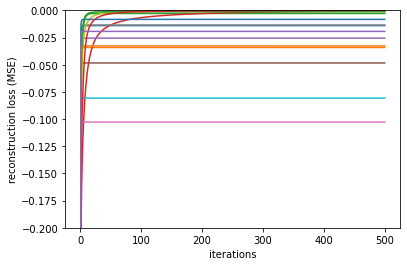

In [28]:
plt.plot(np.stack(outputs).T);
plt.ylim(-0.2, 0)
plt.xlabel("iterations")
plt.ylabel("reconstruction loss (MSE)");

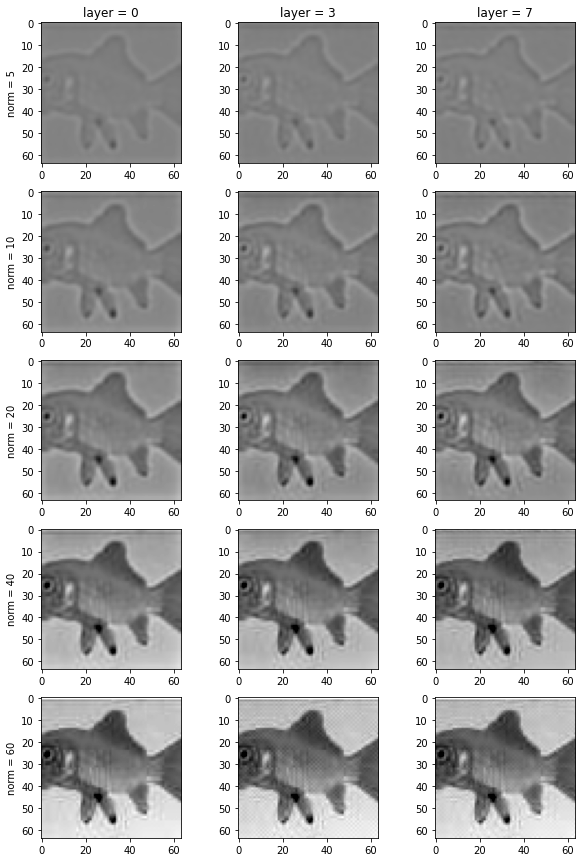

In [29]:
# Plot the reconstructed images, sorted by layer (columns) and norm constraint (rows)
fig, axs = plt.subplots(5,3, figsize=(10,15))
for i, n in enumerate(np.unique(norm)):
    for j, l in enumerate(np.unique(layer)):
        idx = np.where((norm==n) & (layer==l))[0][0]
        axs.ravel()[idx].imshow(reconstructions[idx], cmap="gray", vmin=-1, vmax=1)
        if i == 0:
            axs[i,j].set_title("layer = " + str(l))
        if j == 0:
            axs[i,j].set_ylabel("norm = " + str(n))